# Imports

In [31]:
#Imports
try: 
    from imutils.paths import list_images
    from matplotlib import pyplot as plt
    from scipy.spatial import distance as dist
    from PIL import Image
    import pickle, imutils, cv2, mahotas 
    import numpy as np
    print("Import sucessfull.")
except :
    print("Error occured.")

Import sucessfull.


# Data Preperation

Since images differ from each other, we need a way to standardize the images, e.g white and transparent backgounds to only white backgrouund. 

In [17]:
#Convert all backgrounds to white
def convert_bg_to_white(inp_path, out_path):
    img_path = inp_path
    for spritePath in list_images(img_path):
        image = cv2.imread(spritePath)
        image = Image.open(spritePath).convert("RGBA")
        new_image = Image.new("RGBA", image.size, "WHITE")
        new_image.paste(image, mask=image)
        new_image.convert("RGB").save(out_path+pokemon.split('\\')[1]+".png")
        return 

#  Discritpors and Indexing  

## Colorbased Discriptor ##
<br/>
This Discriptor find and compare Pokemon Images based on color

### Methods of describing and indexing

In [115]:
def img_to_color_hist(image): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def img_to_color_index(inp_path, out_path):
    index = dict()
    for spritePath in list_images(inp_path):
    # parse out the pokemon name, then load the image and
    # convert it to color  hist
        pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
        #print(pokemon)-
        image = cv2.imread(spritePath)
        #print(img_to_color_hist(image))
        index[pokemon] = img_to_color_hist(image)
    f = open(out_path+"/cindex.cpickle", "wb")
    f.write(pickle.dumps(index))
    f.close()
    return 

img_to_color_index("./greyscaled", "./indexes")

### Methods for comaparison

In [138]:
#methods = cv2.HISTCMP_CHISQR or cv2.HISTCMP_BHATTACHARYYA
def search_color_hist(inp_path, idx_path ,method):
    results = dict()
    image =  cv2.imread(inp_path)
    image = cv2.resize(image, [120,120])
    img_hist = img_to_color_hist(image) 
    index = open(idx_path, "rb").read()
    index = pickle.loads(index)
    for hist in index:
        results[hist] = cv2.compareHist(img_hist, index[hist], method)
    results = sorted([(v, k) for (k, v) in results.items()], reverse = False)[:4]
    return results[:4]


In [141]:
print(search_color_hist("./greyscaled/pikachu.png", "./indexes/cindex.cpickle", cv2.HISTCMP_CHISQR))
print("_______________________________")
print(search_color_hist("./greyscaled/pikachu.png", "./indexes/cindex.cpickle", cv2.HISTCMP_BHATTACHARYYA))

[(0.0, 'greyscaled\\pikachu'), (0.06716228993374299, 'greyscaled\\fennekin'), (0.07340109095828327, 'greyscaled\\joltik'), (0.0763622529318233, 'greyscaled\\dunsparce')]
_______________________________
[(0.0, 'greyscaled\\pikachu'), (0.11088218446857463, 'greyscaled\\elekid'), (0.13342980775767146, 'greyscaled\\kakuna'), (0.13417051308940867, 'greyscaled\\sandshrew')]


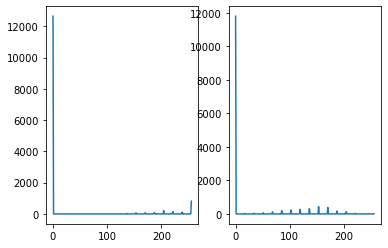

In [157]:
def plot_color_hist(image, title, mask=None):
    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(image) # i removed a
    rgba = [b,g,r] # removing background by method 1 https://stackoverflow.com/questions/40527769/removing-black-background-and-make-transparent-from-grabcut-output-in-python-ope
    dst = cv2.merge(rgba,3)
    chans = cv2.split(dst)
    colors = ("b", "g", "r")
    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    """
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], mask, [256], [0, 256])
        #plt.plot(hist, color=color)
        #plt.xlim([0, 256])
        #plt.savefig(fileslocations+'color.png')
    return hist


fig, axes = plt.subplots(nrows=1, ncols=2)
im0 = axes[0].plot(plot_color_hist(image=cv2.imread("./images/pikachu.png"),title="pika"))
im1 = axes[1].plot(plot_color_hist(image=cv2.imread("./images/onix.png"),title="onix"))



## Shape Discriptor ##

This Discriptor finds and compares Pokemon Images based on shape. 

Functions used for the process of creating an shape discriptor and indexing the outcome. 

1.) img_to_gs_shape: This function takes a image as input, and preprocessing it. Outcome is a black and white segmented image.<br/>
2.) img_to_index: This function loops over all the pokemon database. With the use of img_to_gs_shape() all pokemons are described based on their outline and returned. The described pokemon is indexed in a dictionary where the pokemon acts as key. After all pokemon are indexed, the index is saved to a file 

In [109]:
# Segmentation of the image
def img_to_gs_shape(img): 
        desc = ZernikeMoments(33)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # pad the image with extra white pixels to ensure the
        # edges of the pokemon are not up against the borders
        # of the image
        image = cv2.copyMakeBorder(image, 15, 15, 15, 15,
            cv2.BORDER_CONSTANT, value = 255)
        # invert the image and threshold it
        thresh = cv2.bitwise_not(image)
        thresh[thresh > 0] = 255
        # initialize the outline image, find the outermost
        # contours (the outline) of the pokemone, then draw
        outline = np.zeros(image.shape, dtype = "uint8")
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        cv2.drawContours(outline, [cnts], -1, 255, -1)
        return mahotas.features.zernike_moments(outline, 33)

#Indexing outlined pokemons and saves them to an index file. 
def img_to_index(inp_path, out_path): 
    index = dict()
    for spritePath in list_images(inp_path):
    # parse out the pokemon name, then load the image and
    # convert it to grayscale
        pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
        image = cv2.imread(spritePath)
        index[pokemon] = img_to_gs_shape(image)
    f = open(out_path+"./sindex.cpickle", "wb")
    f.write(pickle.dumps(index))
    f.close()


img_to_index("./greyscaled", "./indexes")

This section aims on comparing and finding pokemons based on new insert images. Therefore the user has to specify an pokemon and based on the already created index, the most similiar pokemon (distance-wise) is outputed. 

In [136]:
###ANNOTATIONS -> For performance reason check if index can be init once
def search_shape_discriptor(index, queryFeatures):
    # initialize our dictionary of results
    results = {}
    # loop over the images in our index
    for (k, features) in index.items():
        # compute the distance between the query features
        # and features in our index, then update the results
        d = dist.euclidean(queryFeatures, features)
        results[k] = d
    # sort our results, where a smaller distance indicates
    # higher similarity
    results = sorted([(v, k) for (k, v) in results.items()])
    # return the results
    return results

[(0.0, 'greyscaled\\pikachu'),
 (0.13052267477446028, 'greyscaled\\frogadier'),
 (0.14533279354262565, 'greyscaled\\scyther'),
 (0.1549367158601479, 'greyscaled\\heracross')]